After talking with Qiming, I would like to perform the following experiment.

In this experiment, I would like to compare the stacked approach an additive approach of OKGT fitting on the following synthesized model.

There are two covariates X1 and X2, while the model only depends on the first covariate as follows $h = \sin(x_1) + e$.

So if we want to explicitly include X2 in the mode, it is written as $h = \sin(x_1) + f(x_2) + \epsilon$ where $f(x_2) = 0$ for all $x_2$.

I want to see if the two approaches of OKGT fitting can recover the true transformations.

In [3]:
%matplotlib inline  

import sys
sys.path.append("/Users/panc25/Dropbox/Research/Zhu_Michael/my_paper/paper_OKGT/software/okgtreg")

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from okgtreg.Data import Data
from okgtreg.Group import Group
from okgtreg.Kernel import Kernel
from okgtreg.OKGTReg import OKGTReg, OKGTReg2

(array([   1.,    1.,    0.,    0.,    3.,    8.,    8.,   10.,   18.,
          23.,   19.,   17.,   16.,   28.,   32.,  133.,   22.,   23.,
          24.,   21.,   15.,   29.,   20.,   18.,    4.,    4.,    1.,
           0.,    1.,    1.]),
 array([-2.09175616, -1.95481118, -1.81786621, -1.68092124, -1.54397627,
        -1.4070313 , -1.27008633, -1.13314135, -0.99619638, -0.85925141,
        -0.72230644, -0.58536147, -0.4484165 , -0.31147153, -0.17452655,
        -0.03758158,  0.09936339,  0.23630836,  0.37325333,  0.5101983 ,
         0.64714327,  0.78408825,  0.92103322,  1.05797819,  1.19492316,
         1.33186813,  1.4688131 ,  1.60575808,  1.74270305,  1.87964802,
         2.01659299]),
 <a list of 30 Patch objects>)

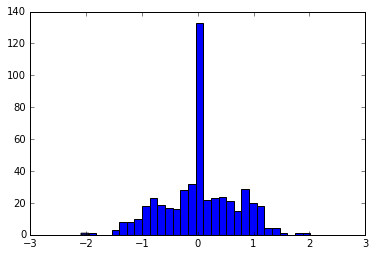

In [7]:
# Create model
def model(n):
    p = 2
    x = np.random.standard_normal((n,p))
    e = np.random.standard_normal(n) * 0.1
    h = np.sin(x[:,0] * np.pi) + e
    y = h**3
    return Data(y, x), Group([1], [2]), h

# Simulate data
n = 500
np.random.seed(25)
data, true_gstruct, h = model(n)

plt.hist(data.y, 30)

In [8]:
# Kernel
# kernel = Kernel('gaussian', sigma=0.5)
kernel = Kernel('laplace', sigma=0.5)

In [10]:
# OKGTReg using stacked approach
okgt_stack = OKGTReg(data, kernel=kernel, group=true_gstruct)
fit_stack = okgt_stack.train()
print "R2 (stacked) = %.05f" % fit_stack['r2']

R2 (stacked) = 0.99453


In [11]:
# OKGTReg using additive approach
okgt_add = OKGTReg2(data, kernel=kernel, group=true_gstruct)
fit_add = okgt_add.train()
print "R2 (additive) = %.05f" % fit_add['r2']

R2 (additive) = 0.99465


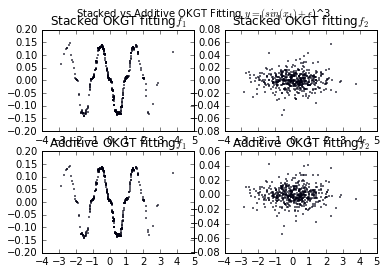

In [14]:
# Plot transformations
## list all four plots in a figure
fig, axarr = plt.subplots(2, 2)
fig.suptitle("Stacked vs Additive OKGT Fitting " +
             r"$y = (sin(x_1) + \epsilon$)^3")

axarr[0,0].set_title("Stacked OKGT fitting" + r'$f_1$')
axarr[0,0].scatter(data.X[:,0], fit_stack['f'][:,0], s=0.5)
axarr[0,1].set_title("Stacked OKGT fitting" + r'$f_2$')
axarr[0,1].scatter(data.X[:,0], fit_stack['f'][:,1], s=0.5)

axarr[1,0].set_title("Additive OKGT fitting" + r'$f_1$')
axarr[1,0].scatter(data.X[:,0], fit_add['f'][:,0], s=0.5)
axarr[1,1].set_title("Additive OKGT fitting" + r'$f_2$')
axarr[1,1].scatter(data.X[:,0], fit_add['f'][:,1], s=0.5)

So we can see that the fitting from both approaches are very similar. In addition, both approaches successfully identify that the $f_1$ is a sin function and $f_2$ has no clear pattern (though $f_2$ is not exactly a horizontal line).

This makes us very curious what is the relationship between the expansion coefficients of the kernel basis from the two approaches. Specifically, let $\alpha_1$ and $\alpha_2$ for the expansion coeffients for $K_1$ and $K_2$ in the stacked approach. Let $\beta$ for the common expansion coefficients for $K_1$ and $K_2$ in the additive approach. **What can we say about the relationship between ($\alpha_1$, $\alpha_2$) and $\beta$**?

By modifying the code, we can capture the values of ($\alpha_1$, $\alpha_2$) and $\beta$. The following lists the cosine distance between each pair of the three vectors:

1. $1 - cos(\alpha_1, \beta) = 0.25158$
2. $1 - cos(\alpha_2, \beta) = 0.22805$
3. $1 - cos(\alpha_1, \alpha_2) = 0.75196$

The consine between the averge of $0.5 \alpha_1 + 0.5 \alpha_2$ and $\beta$ is 0.03768.

**So is it the case that using the additive approach is equivalent to taking the average of the stacked approach?**

# What if we use a bi-variate kernel function?

It is conjectured that the dimension of X2 would vanish since the model is independent of the covariate.

R2 (stacked, bi-variate kernel) = 0.99755


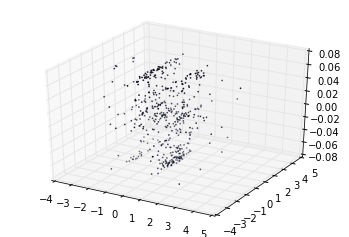

In [16]:
gstruct2 = Group([1,2])

okgt2_stack = OKGTReg(data, kernel=kernel, group=gstruct2)
fit2_stack = okgt2_stack.train()
print "R2 (stacked, bi-variate kernel) = %.05f" % fit2_stack['r2']

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data.X[:,0], data.X[:,1], fit2_stack['f'][:,0], s=0.5)

# okgt2_add = OKGTReg2(data, kernel=kernel, group=gstruct2)
# fit2_add = okgt2_add.train()
# print "R2 (additive, bi-variate kernel) = %.05f" % fit2_add['r2']

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(data.X[:,0], data.X[:,1], fit2_add['f'][:,0], s=0.5)